In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import json

In [2]:
# Suppress convergence warnings for readability
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the dataset
df = pd.read_csv('WSN-DS.csv')

# Handle missing values
df = df.dropna()

# Convert categorical variables to numerical
df['Attack type'] = pd.Categorical(df['Attack type']).codes

# Separate features and target
X = df.drop(['Attack type'], axis=1)
y = df['Attack type']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
# Display unique values in the original 'Attack type' column
original_attack_types = pd.read_csv('WSN-DS.csv')['Attack type'].unique()
print("Original Attack Type Names:")
print(original_attack_types)

# Map category codes back to original labels
df_original = pd.read_csv('WSN-DS.csv')  # Reload the original dataset
attack_type_mapping = dict(enumerate(pd.Categorical(df_original['Attack type']).categories))

# Display the mapping
print("Attack Type Mapping:")
for num, attack in attack_type_mapping.items():
    print(f"{num} -> {attack}")

Original Attack Type Names:
['Normal' 'Flooding' 'TDMA' 'Grayhole' 'Blackhole']
Attack Type Mapping:
0 -> Blackhole
1 -> Flooding
2 -> Grayhole
3 -> Normal
4 -> TDMA


In [4]:
# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Columns to check for outliers
numeric_columns = [' Dist_To_CH', ' dist_CH_To_BS', 'Expaned Energy', 
                  ' DATA_S', ' DATA_R', ' Data_Sent_To_BS']

# Remove outliers
df_clean = remove_outliers(df, numeric_columns)

print(f"Original dataset size: {len(df)}")
print(f"Dataset size after removing outliers: {len(df_clean)}")

Original dataset size: 374661
Dataset size after removing outliers: 263542


In [5]:
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Second split: separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [6]:
# Basic Statistics
print("Dataset Statistics:")
display(df.describe().style.format("{:.3f}")
                    .set_properties(**{'text-align': 'center'})
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))

# Class Distribution
print("\nClass Distribution:")
class_dist = pd.DataFrame(df['Attack type'].value_counts(normalize=True))
class_dist.columns = ['Percentage']
display(class_dist.style.format("{:.2%}")
                      .set_properties(**{'text-align': 'center'})
                      .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))

Dataset Statistics:


,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
count,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000,374661.000
mean,274969.326,1064.749,0.116,274980.411,22.599,0.268,6.941,0.780,0.737,0.289,0.747,9.687,44.858,73.890,4.569,22.563,2.498,0.306,2.881
std,389898.555,899.646,0.320,389911.222,21.956,2.061,7.044,0.414,4.691,2.755,0.434,14.682,42.574,230.246,19.679,50.262,2.407,0.669,0.565
min,101000.000,50.000,0.000,101000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,107093.000,353.000,0.000,107096.000,4.735,0.000,3.000,1.000,0.000,0.000,0.000,1.000,13.000,0.000,0.000,0.000,1.000,0.056,3.000
50%,116071.000,803.000,0.000,116072.000,18.373,0.000,5.000,1.000,0.000,0.000,1.000,3.000,35.000,0.000,0.000,0.000,2.000,0.098,3.000
75%,215072.000,1503.000,0.000,215073.000,33.776,0.000,7.000,1.000,0.000,0.000,1.000,13.000,62.000,0.000,0.000,0.000,4.000,0.218,3.000
max,3402096.000,3600.000,1.000,3402100.000,214.275,97.000,117.000,1.000,124.000,99.000,1.000,99.000,241.000,1496.000,241.000,201.935,15.000,45.094,4.000



Class Distribution:


,Percentage
Attack type,
3,90.77%
2,3.90%
0,2.68%
4,1.77%
1,0.88%


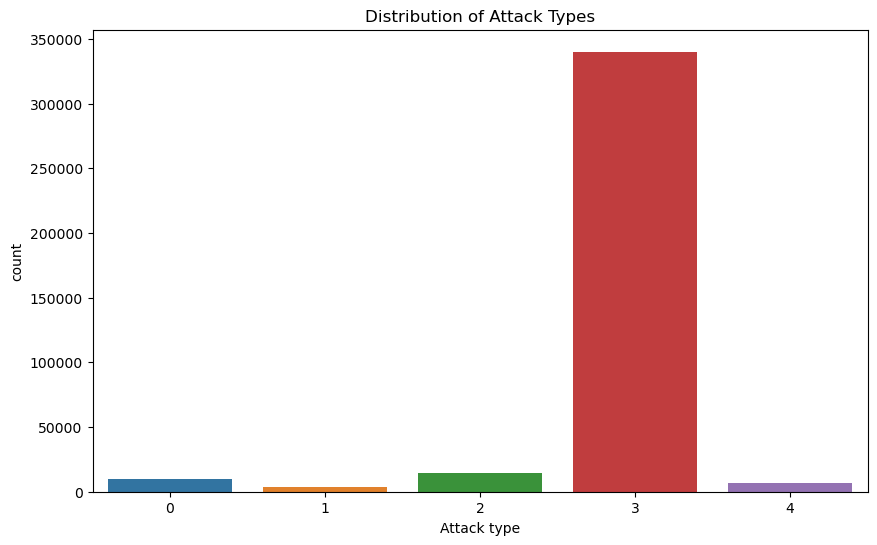

In [7]:
# Data distribution analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Attack type')
plt.title('Distribution of Attack Types')
plt.savefig('attack_distribution.png')

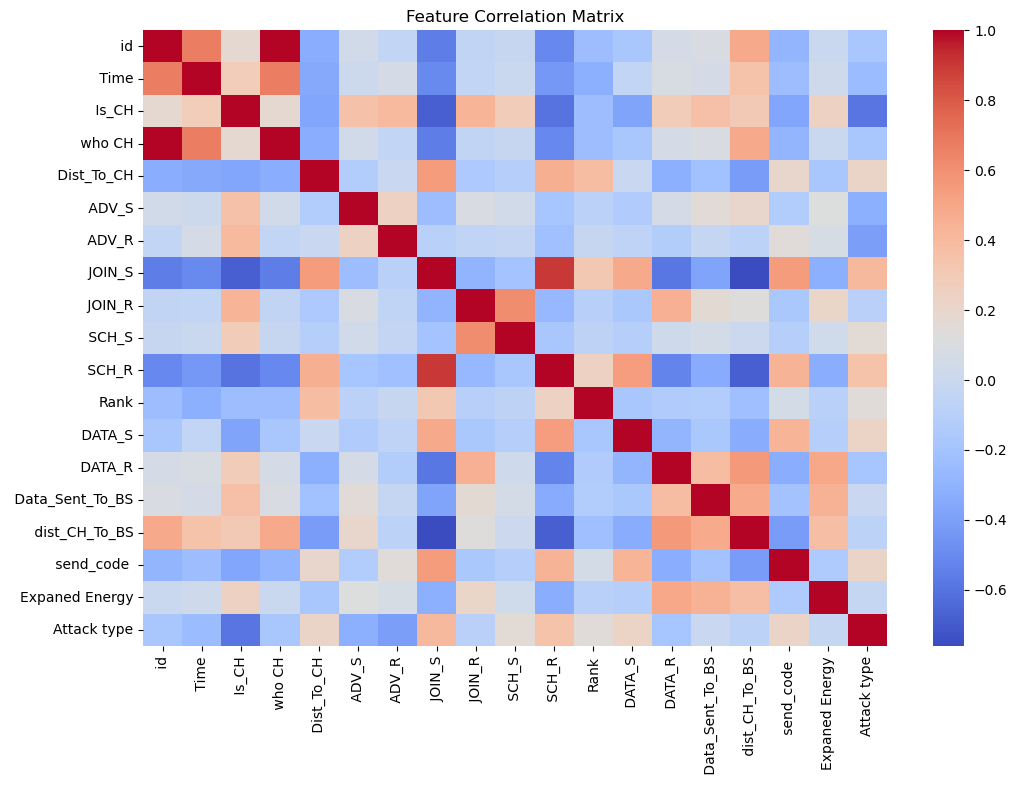

In [8]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')

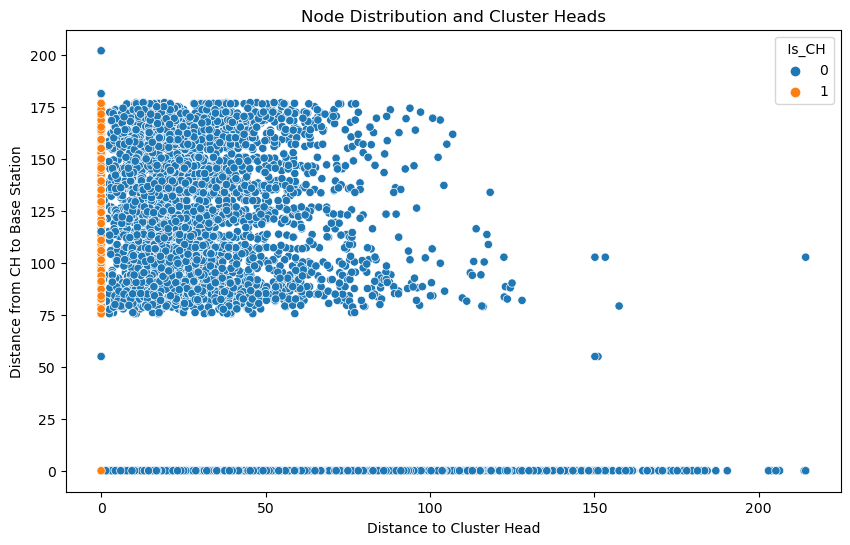

In [9]:
# Node Distribution Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=' Dist_To_CH', y=' dist_CH_To_BS', hue=' Is_CH')
plt.title('Node Distribution and Cluster Heads')
plt.xlabel('Distance to Cluster Head')
plt.ylabel('Distance from CH to Base Station')
plt.savefig('node distribution.png')

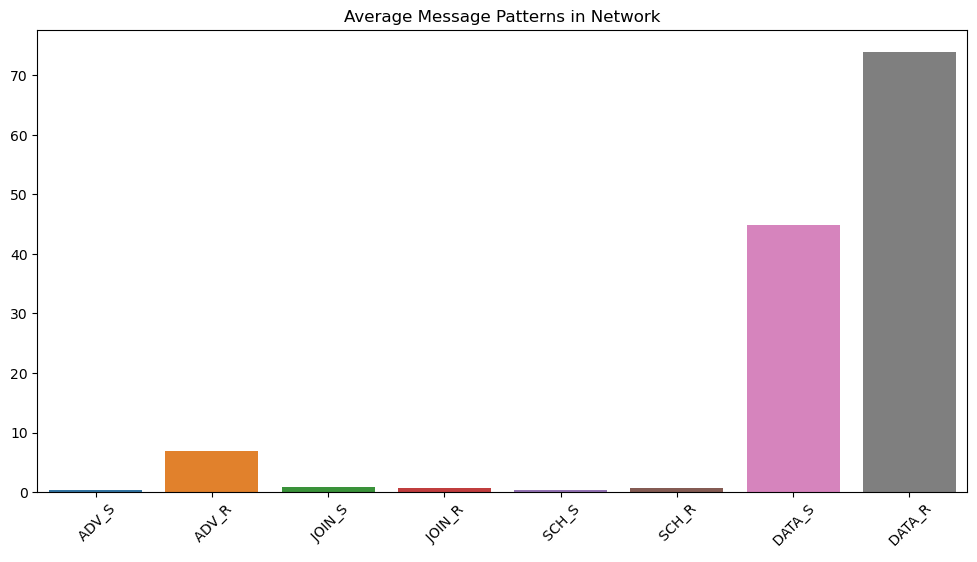

In [10]:
# Communication Pattern Analysis
message_cols = [' ADV_S', ' ADV_R', ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', ' DATA_S', ' DATA_R']
msg_patterns = df[message_cols].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=msg_patterns.index, y=msg_patterns.values)
plt.title('Average Message Patterns in Network')
plt.xticks(rotation=45)
plt.savefig('avg message patterns.png')

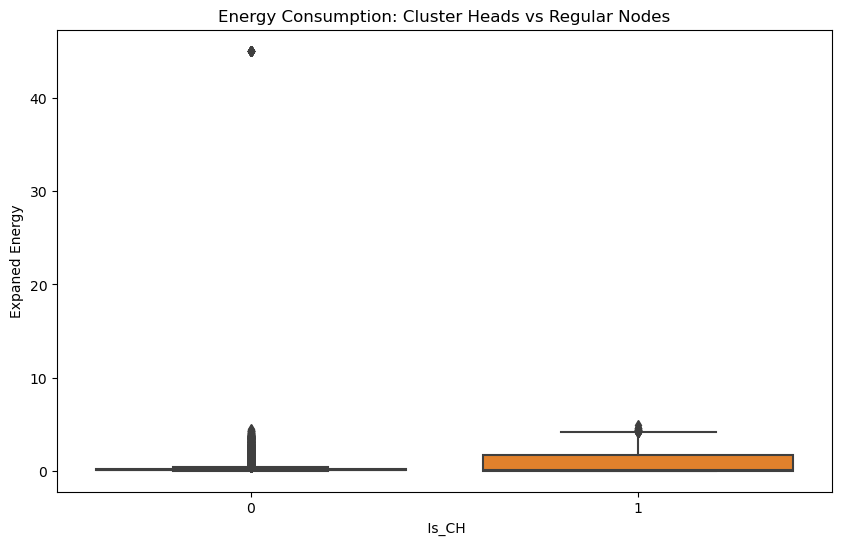

In [11]:
# Energy Analysis by Node Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x=' Is_CH', y='Expaned Energy')
plt.title('Energy Consumption: Cluster Heads vs Regular Nodes')
plt.savefig('energy consumption.png')

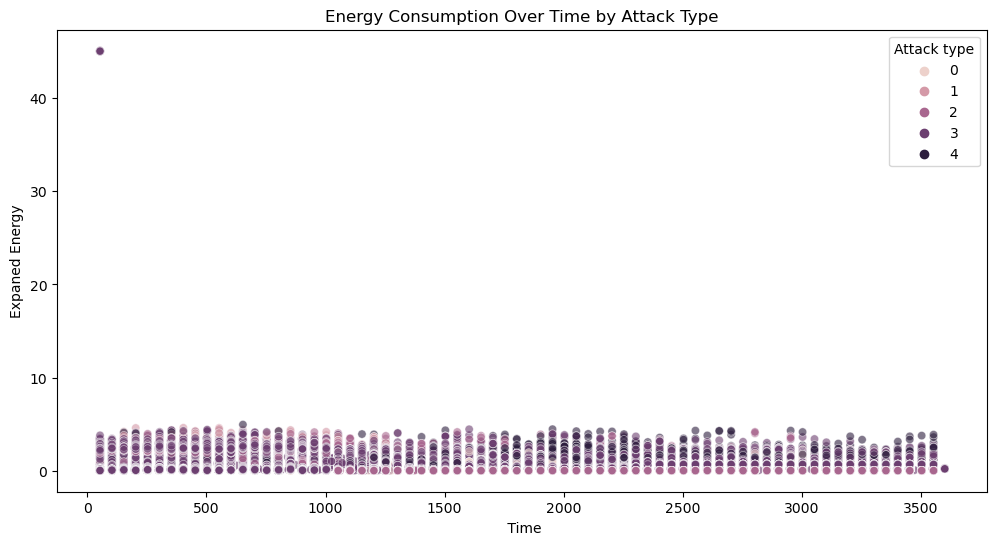

In [12]:
# Time-based Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x=' Time', y='Expaned Energy', hue='Attack type', alpha=0.6)
plt.title('Energy Consumption Over Time by Attack Type')
plt.savefig('time based.png')

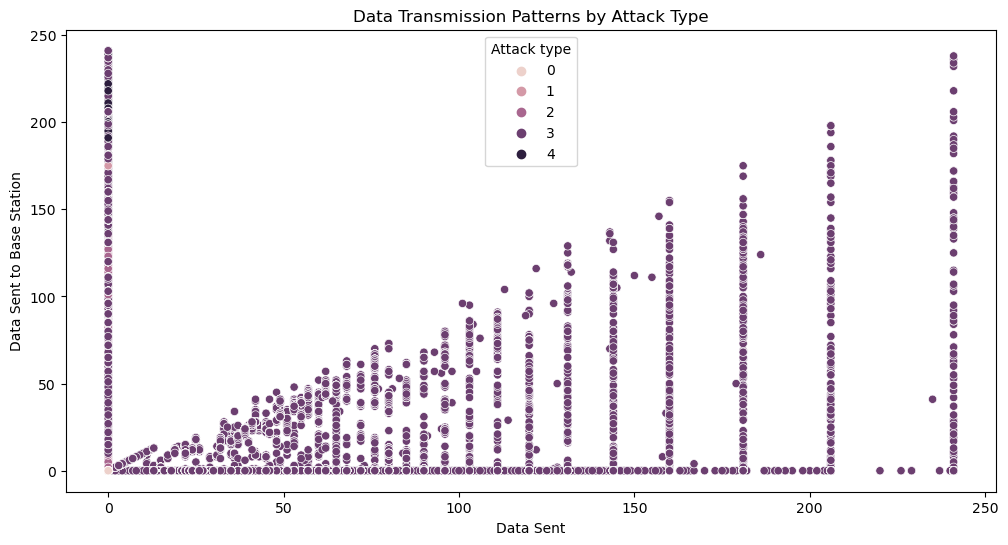

In [13]:
# Data Transmission Patterns
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x=' DATA_S', y=' Data_Sent_To_BS', hue='Attack type')
plt.title('Data Transmission Patterns by Attack Type')
plt.xlabel('Data Sent')
plt.ylabel('Data Sent to Base Station')
plt.savefig('data transmission.png')

In [14]:
# Statistical Summary
stats_summary = df.groupby('Attack type').agg({
    'Expaned Energy': ['mean', 'std'],
    ' DATA_S': 'sum',
    ' dist_CH_To_BS': 'mean'
}).round(3)

display(stats_summary.style.format("{:.3f}")
                    .set_properties(**{'text-align': 'center'})
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))

In [15]:
# Ensure model save directory exists
model_save_path = "models/"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Dictionary to store results
model_results = {}

In [16]:
# Logistic Regression model and grid
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000, 2000]
}

# Perform Randomized Search
log_reg_random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=log_reg_param_grid,
    n_iter=10,  # Reduce to 10 random combinations
    cv=2,  # Reduce folds to 2
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
log_reg_random_search.fit(X_train, y_train)

# Best model
best_log_reg = log_reg_random_search.best_estimator_
print("Best Logistic Regression Parameters:", log_reg_random_search.best_params_)
print("Best Logistic Regression Accuracy:", log_reg_random_search.best_score_)

# Save model
joblib.dump(best_log_reg, f"{model_save_path}Logistic_Regression_Best.pkl")

# Validation metrics
y_val_pred = best_log_reg.predict(X_val)
model_results['Logistic Regression'] = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Logistic Regression Parameters: {'solver': 'lbfgs', 'max_iter': 2000, 'C': 10}
Best Logistic Regression Accuracy: 0.9741587928610829
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2028
           1       0.91      0.90      0.90       659
           2       0.73      0.67      0.70      2908
           3       0.99      1.00      1.00     67986
           4       0.98      0.91      0.94      1351

    accuracy                           0.97     74932
   macro avg       0.86      0.85      0.85     74932
weighted avg       0.97      0.97      0.97     74932

[[ 1579     0   449     0     0]
 [    0   594     0    65     0]
 [  768     0  1957   167    16]
 [    0    60   255 67658    13]
 [    0     0     3   119  1229]]


In [17]:
# Random Forest model and grid
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Perform Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_grid,
    n_iter=20,  # Reduce to 20 random combinations
    cv=2,  # Reduce folds to 2
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

# Best model
best_rf = rf_random_search.best_estimator_
print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Random Forest Accuracy:", rf_random_search.best_score_)

# Save model
joblib.dump(best_rf, f"{model_save_path}Random_Forest_Best.pkl")

# Validation metrics
y_val_pred = best_rf.predict(X_val)
model_results['Random Forest'] = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Random Forest Accuracy: 0.9964278723820708
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2028
           1       0.94      0.99      0.97       659
           2       0.99      0.99      0.99      2908
           3       1.00      1.00      1.00     67986
           4       1.00      0.92      0.96      1351

    accuracy                           1.00     74932
   macro avg       0.98      0.98      0.98     74932
weighted avg       1.00      1.00      1.00     74932

[[ 2024     0     4     0     0]
 [    1   652     0     6     0]
 [   21     0  2865    22     0]
 [    0    38    24 67922     2]
 [    0     0     1   101  1249]]


In [18]:
# Gradient Boosting model and grid
gb_clf = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Perform Randomized Search
gb_random_search = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=gb_param_grid,
    n_iter=15,  # Reduce to 15 random combinations
    cv=2,  # Reduce folds to 2
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
gb_random_search.fit(X_train, y_train)

# Best model
best_gb = gb_random_search.best_estimator_
print("Best Gradient Boosting Parameters:", gb_random_search.best_params_)
print("Best Gradient Boosting Accuracy:", gb_random_search.best_score_)

# Save model
joblib.dump(best_gb, f"{model_save_path}Gradient_Boosting_Best.pkl")

# Validation metrics
y_val_pred = best_gb.predict(X_val)
model_results['Gradient Boosting'] = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best Gradient Boosting Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best Gradient Boosting Accuracy: 0.9956093524795815
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2028
           1       0.95      0.98      0.96       659
           2       0.99      0.98      0.99      2908
           3       1.00      1.00      1.00     67986
           4       0.94      0.93      0.94      1351

    accuracy                           1.00     74932
   macro avg       0.97      0.98      0.98     74932
weighted avg       1.00      1.00      1.00     74932

[[ 2017     0    11     0     0]
 [    0   646     0    12     1]
 [   20     0  2863    22     3]
 [    1    36    24 67855    70]
 [    0     0     0    99  1252]]


In [19]:
# SVC model and grid
svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01]
}

# Perform Randomized Search
svc_random_search = RandomizedSearchCV(
    estimator=svc_clf,
    param_distributions=svc_param_grid,
    n_iter=5,  # Reduce to 5 random combinations
    cv=2,  # Reduce folds to 2
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
svc_random_search.fit(X_train, y_train)

# Best model
best_svc = svc_random_search.best_estimator_
print("Best SVC Parameters:", svc_random_search.best_params_)
print("Best SVC Accuracy:", svc_random_search.best_score_)

# Save model
joblib.dump(best_svc, f"{model_save_path}Support_Vector_Best.pkl")

# Validation metrics
y_val_pred = best_svc.predict(X_val)
model_results['Support Vector Classifier'] = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best SVC Parameters: {'gamma': 'scale', 'C': 10}
Best SVC Accuracy: 0.9854445808644281
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      2028
           1       0.92      0.99      0.95       659
           2       0.90      0.78      0.83      2908
           3       1.00      1.00      1.00     67986
           4       1.00      0.92      0.96      1351

    accuracy                           0.99     74932
   macro avg       0.91      0.91      0.91     74932
weighted avg       0.99      0.99      0.99     74932

[[ 1798     0   230     0     0]
 [    0   650     0     9     0]
 [  615     0  2268    25     0]
 [    1    59    30 67894     2]
 [    0     0     1   106  1244]]


In [20]:
# XGBoost model and grid
xgb_clf = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform Randomized Search
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Reduce to 20 random combinations
    cv=2,  # Reduce folds to 2
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
xgb_random_search.fit(X_train, y_train)

# Best model
best_xgb = xgb_random_search.best_estimator_
print("Best XGBoost Parameters:", xgb_random_search.best_params_)
print("Best XGBoost Accuracy:", xgb_random_search.best_score_)

# Save model
joblib.dump(best_xgb, f"{model_save_path}XGBoost_Best.pkl")

# Validation metrics
y_val_pred = best_xgb.predict(X_val)
model_results['XGBoost'] = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best XGBoost Accuracy: 0.9966947810459261
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2028
           1       0.95      0.98      0.97       659
           2       0.99      0.98      0.99      2908
           3       1.00      1.00      1.00     67986
           4       1.00      0.93      0.96      1351

    accuracy                           1.00     74932
   macro avg       0.98      0.98      0.98     74932
weighted avg       1.00      1.00      1.00     74932

[[ 2019     0     9     0     0]
 [    0   649     0    10     0]
 [   25     0  2859    24     0]
 [    1    33    22 67928     2]
 [    0     0     0   101  1250]]


In [21]:
# Model results after training
model_results = {
    "Logistic Regression": 0.9742,
    "Random Forest": 0.9964,
    "Gradient Boosting": 0.9954,
    "Support Vector Classifier": 0.9854,
    "XGBoost": 0.9968
}

# Save to JSON file
comparison_file = "model_comparison.json"
with open(comparison_file, "w") as f:
    json.dump(model_results, f)

print(f"Model comparison saved to {comparison_file}")

Model comparison saved to model_comparison.json


In [22]:
# Evaluate the best model on the test set
best_model_filename = f"{model_save_path}XGBoost_Best.pkl"
best_model = joblib.load(best_model_filename)

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Evaluation Metrics
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9969


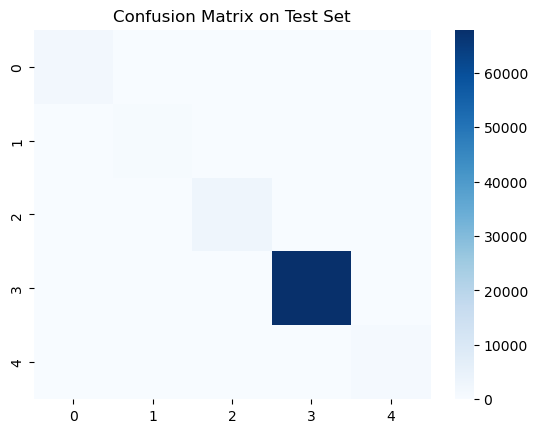

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.savefig("confusion_matrix_test.png")
plt.show()

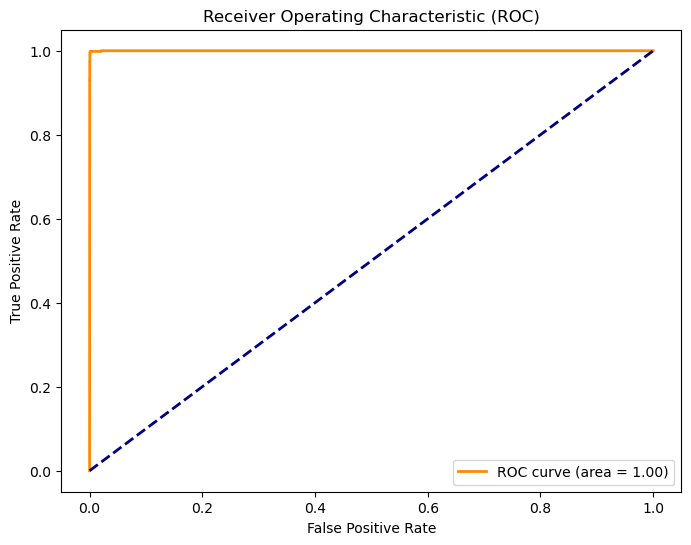

In [24]:
# ROC Curve
if hasattr(best_model, "predict_proba"):
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_test.png")
    plt.show()

In [33]:
def predict_from_user_input_v2_fixed(model_path, scaler, attack_type_mapping):
    """
    Predict the class of a single instance based on user input.

    Parameters:
        model_path (str): Path to the saved model file.
        scaler (StandardScaler): Scaler used for training the model.
        attack_type_mapping (dict): Mapping of numerical labels to original class labels.

    Returns:
        None
    """
    # Load the saved model
    model = joblib.load(model_path)
    print(f"Model loaded from {model_path}\n")

    # Define the exact feature columns used during training (including 'id')
    feature_columns = [
        ' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R', ' JOIN_S', ' JOIN_R',
        ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R', ' Data_Sent_To_BS',
        ' dist_CH_To_BS', ' send_code ', 'Expaned Energy'
    ]

    # Prompt the user for input values
    print("Enter the values for the following features:")
    user_input = {}
    for feature in feature_columns:
        feature_cleaned = feature.strip()  # Remove leading/trailing spaces for display
        if feature_cleaned == "id":
            user_input[feature] = 0  # Default value for 'id'
        else:
            value = float(input(f"{feature_cleaned}: "))
            user_input[feature] = value

    # Convert user input to a DataFrame
    input_data = pd.DataFrame([user_input])

    # Reorder columns to match the training dataset
    input_data = input_data[feature_columns]  # Ensure column order matches training data

    # Scale the input data
    input_data_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = model.predict(input_data_scaled)[0]

    # Map the numerical prediction back to the original label
    predicted_label = attack_type_mapping[prediction]
    print(f"\nPredicted Attack Type: {predicted_label}")

# Example usage:
if __name__ == "__main__":
    # Ensure scaler and model paths are properly initialized
    best_model_path = f"{model_save_path}XGBoost_Best.pkl"  # Path to the best model
    scaler = StandardScaler().fit(X)  # Reuse the scaler used for training
    
    # Map category codes back to original labels
    attack_type_mapping = dict(enumerate(pd.Categorical(df_original['Attack type']).categories))

    # Call the updated prediction function
    predict_from_user_input_v2_fixed(best_model_path, scaler, attack_type_mapping)

Model loaded from models/XGBoost_Best.pkl

Enter the values for the following features:
Time: 303
Is_CH: 1
who CH: 106040
Dist_To_CH: 0
ADV_S: 1
ADV_R: 1
JOIN_S: 0
JOIN_R: 89
SCH_S: 89
SCH_R: 0
Rank: 0
DATA_S: 0
DATA_R: 0
Data_Sent_To_BS: 0
dist_CH_To_BS: 0
send_code: 0
Expaned Energy: 0.00724

Predicted Attack Type: TDMA


In [26]:
df.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,3
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,3
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,3
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,3
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,3
